<h2>PyTorch example of a simple convolution network model</h2>
Trained and tested using the MNIST dataset

Taken from: https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/convolutional_neural_network/main.py#L35-L56

Initialization

In [53]:
import time
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.metrics import confusion_matrix
import itertools

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data/',
                                          train=False, 
                                          transform= transforms.ToTensor())
                                        

In [54]:
'''Learning Curve Plot Utility'''
def plot(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
  fig, axs = plt.subplots(1, 2, figsize=(11,5))

  ax = axs[0]
  ax.set_title("Model Loss", fontsize=12)
  ax.plot(train_loss_history, label="Training")
  ax.plot(val_loss_history,   label="Validation")
  ax.set_xlabel("Epoch",        fontsize=12)
  ax.set_ylabel("Average loss", fontsize=12)
  ax.legend(loc="best",         fontsize=12)

  ax = axs[1]
  ax.set_title("Model Accuracy", fontsize=12)
  ax.plot(train_acc_history, label="Training")
  ax.plot(val_acc_history,   label="Validation")
  ax.set_xlabel("Epoch",        fontsize=12)
  ax.set_ylabel("Accuracy",     fontsize=12)
  ax.set_ylim(0,1)
  ax.legend(loc="best",         fontsize=12)

## Utilities
These functions provide Learning curve plots and lerning progress reports 

In [55]:
'''Learning progress utility'''
def log_progress(running_loss, curr_batch, batch_size, curr_epoch, total_epochs, dataloader):
    """
    Prints message logging progress through training.
    """
    progress = float(curr_batch + 1)/(float(len(dataloader.dataset)) / batch_size)
    log = "EPOCH [{}/{}]. Running Loss: {} Progress: {} % ".format(
        curr_epoch + 1, total_epochs, round(running_loss, 2), round(progress * 100, 2))
    print(log)

In [56]:
#  preserntation for a confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



In [70]:
# Hyperparameters
num_epochs = 6
num_classes = 10
batch_size = 128
learning_rate = 0.2

In [58]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

## Model

In [67]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Sequential(
            nn.Linear(7*7*64, 256),
            nn.ReLU())
        self.fc2 = nn.Linear(256, num_classes)
        self.soft_max = nn.Softmax()
        self.drop_out = nn.Dropout(p=0.3)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop_out(out)
        out = self.fc2(out)
        out = self.soft_max(out)
        return out

model = ConvNet(num_classes).to(device)


```
# 1, 16, 16, 32, 0.9894, lr=0.2
# 1,32 32,64 0.9909, lr=0.2
# 1,48 48 96, 0.9901, lr=0.2
# 1,64 64,128 0.2, lr=0.2

num_epochs = 12
num_classes = 10
batch_size = 128
learning_rate = 0.1 
1,32,32,64: 0.992 accuracy


dense layer:
128 = 991
256 =9915
512 =9895

1,32,32,64, dense 256, dropout:
0.2 9911
0.3 9923
0.4 991
0.5 9894

```




## Training 

In [72]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate) # Changed to Adadelta with lr=1.0

# Keep track of average losses, training accuracy and validation accuracy for each epoch
train_loss_history = np.zeros(num_epochs)
train_acc_history  = np.zeros(num_epochs)
val_loss_history   = np.zeros(num_epochs)
val_acc_history    = np.zeros(num_epochs)

start_time = datetime.now()

for epoch in range(num_epochs):

  # Place network in training mode
  model.train()

  # Initialize running epoch loss and number correctly classified
  running_loss   = 0.0
  num_correct    = 0.0
  total_images   = 0.0

  for batch_num, (inputs, labels) in enumerate(train_loader):
      # [inputs] and [labels] is one batch of images and their classes
      inputs = inputs.to(device)
      labels = labels.to(device)

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Update statistics for this batch
      curr_loss = loss.item()
      _, preds = torch.max(outputs, 1)
      curr_images = labels.cpu().data.numpy().size
      curr_correct = torch.sum(preds == labels.data.reshape(-1))

      # Update running statistics for this epoch
      running_loss += curr_loss
      num_correct += curr_correct
      total_images += curr_images

      # Log Progress every 200 batches
      if (batch_num + 1) % 200 == 0:
        log_progress(running_loss, batch_num, batch_size, epoch, num_epochs, train_loader)

  # Update statistics for epoch
  train_loss_history[epoch] = curr_loss #running_loss / total_images
  train_acc_history[epoch]  = float(num_correct)  / float(total_images)
  print("Train Avg. Loss: [{}] Acc: {} on {} images".format(
      round(train_loss_history[epoch],4), round(train_acc_history[epoch],4), total_images) )

  # ============================ Validation ==============================
  print("Validating...")
  # Place network in testing mode (won't need to keep track of gradients)
  model.eval()

  running_loss   = 0.0
  num_correct    = 0.0
  total_images   = 0.0

  for batch_num, (inputs, labels) in enumerate(test_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      # Propagate batch through network
      outputs  = model(inputs)
      loss     = criterion(outputs, labels.squeeze())
      _, preds = torch.max(outputs, 1)

      # Update statistics for this batch
      running_loss  += loss.item()
      num_correct   += torch.sum(preds == labels.data.reshape(-1))
      total_images  += labels.cpu().data.numpy().size

      # Log Progress every 200 batches
      if (batch_num + 1) % 200 == 0:
        log_progress(running_loss, batch_num, batch_size, epoch, num_epochs, test_loader)    

  # Update statistics for validation data
  val_loss_history[epoch] = loss.item() #running_loss / total_images
  val_acc_history[epoch]  = float(num_correct)  / float(total_images) 
  print("Val Avg. Loss: [{}] Acc: {} on {} images\n".format(
      round(val_loss_history[epoch],4), val_acc_history[epoch], total_images))

print("Time Elapsed: {} seconds".format((datetime.now() - start_time).total_seconds()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH [1/6]. Running Loss: 293.56 Progress: 42.67 % 
EPOCH [1/6]. Running Loss: 587.22 Progress: 85.33 % 
Train Avg. Loss: [1.476] Acc: 0.9942 on 60000.0 images
Validating...
Val Avg. Loss: [1.4612] Acc: 0.9911 on 10000.0 images

EPOCH [2/6]. Running Loss: 293.56 Progress: 42.67 % 
EPOCH [2/6]. Running Loss: 587.0 Progress: 85.33 % 
Train Avg. Loss: [1.4716] Acc: 0.9948 on 60000.0 images
Validating...
Val Avg. Loss: [1.4612] Acc: 0.9915 on 10000.0 images

EPOCH [3/6]. Running Loss: 293.42 Progress: 42.67 % 
EPOCH [3/6]. Running Loss: 586.72 Progress: 85.33 % 
Train Avg. Loss: [1.4889] Acc: 0.9952 on 60000.0 images
Validating...
Val Avg. Loss: [1.4612] Acc: 0.9915 on 10000.0 images

EPOCH [4/6]. Running Loss: 293.42 Progress: 42.67 % 
EPOCH [4/6]. Running Loss: 586.57 Progress: 85.33 % 
Train Avg. Loss: [1.4794] Acc: 0.9957 on 60000.0 images
Validating...
Val Avg. Loss: [1.4612] Acc: 0.9911 on 10000.0 images

EPOCH [5/6]. Running Loss: 293.29 Progress: 42.67 % 
EPOCH [5/6]. Running Loss

## Learning curve plots

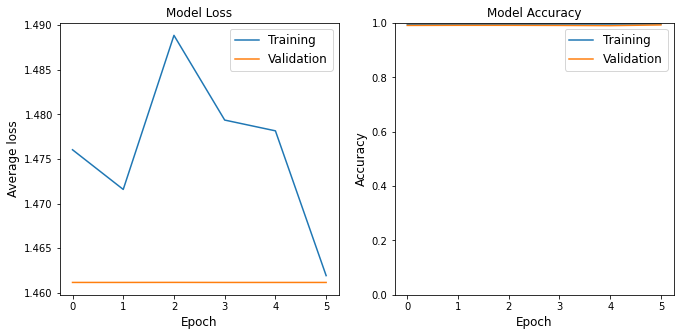

In [73]:
plot(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

In [74]:
# Test the model
ytest = []
rtest = np.ones((0,10))
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        ytest = np.append(ytest, labels)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        rtest = np.append(rtest, outputs.cpu(), axis=0)
print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test Accuracy of the model on the 10000 test images: 99.29 %


Confusion matrix, without normalization


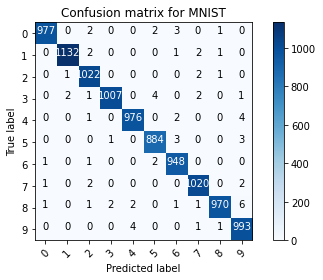

In [75]:
cfm = confusion_matrix(np.argmax (rtest,axis=1), ytest)
plot_confusion_matrix(cfm, classes=range(10), 
                      title='Confusion matrix for MNIST')

In [ ]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')